Epoch 1, Loss: 0.13377850547458714
Epoch 2, Loss: 0.0424360839631046
Epoch 3, Loss: 0.0290831079997619
Epoch 4, Loss: 0.020553104307957745
Epoch 5, Loss: 0.016027073609424996
Epoch 6, Loss: 0.012774369801591403
Epoch 7, Loss: 0.010211660109351152
Epoch 8, Loss: 0.008947213998262891
Epoch 9, Loss: 0.006667164928838097
Epoch 10, Loss: 0.0078187652872204
Accuracy: 99.21%
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


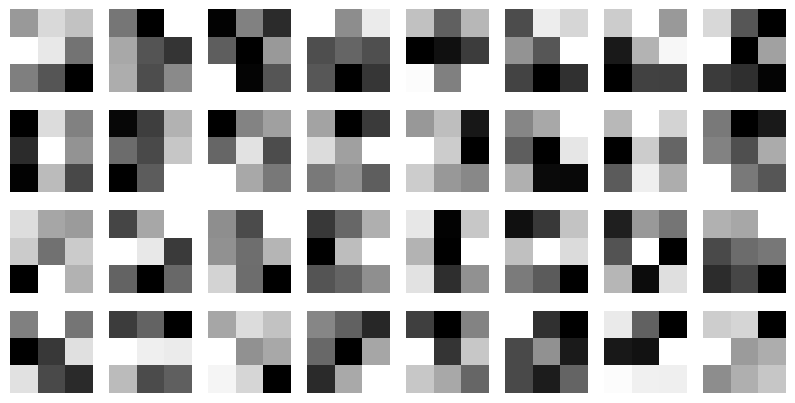

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt

# Define the CNN model
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize the model, loss function, and optimizer
model = MNISTModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")

# Function to make a prediction on a custom image
def predict_digit(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    image = transform(image).unsqueeze(0)
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    return predicted.item()

# Visualizing weights of the first layer
def visualize_weights():
    weights = model.conv1.weight.data.numpy()
    fig, axes = plt.subplots(4, 8, figsize=(10, 5))
    for i, ax in enumerate(axes.flatten()):
        if i < weights.shape[0]:
            ax.imshow(weights[i, 0, :, :], cmap='gray')
            ax.axis('off')
    plt.show()

# Gradio interface
def classify_image(image):
    label = predict_digit(image)
    return label

gr.Interface(fn=classify_image, 
             inputs=gr.Image(shape=(28, 28), image_mode='L', invert_colors=True),
             outputs=gr.Label(), 
             live=True).launch()

# Visualize weights
visualize_weights()
